# Measuring placebo effect on hunger

In this example we show show to measure the impact of placebo on hunger.

We model how hunger, $h(t)$, changes over time, $t$, over the course of $T$ hours, after taking a tablet, and given a communication based intervention, $i \in \{0, 1\}$.  
Each participant will do this twice with different $i$ interventions.

In [1]:

import os

import jax.random

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"
from jax import config

config.update("jax_enable_x64", True)
import numpy as np
import tensorflow_probability.substrates.jax as tfp
from jax import numpy as jnp

from jaxns import Prior

tfpd = tfp.distributions

/tmp/ipykernel_24225/661831631.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax import config
INFO[2024-01-31 23:12:36,070]: Unable to initialize backend 'cuda': 
INFO[2024-01-31 23:12:36,070]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-01-31 23:12:36,072]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2024-01-31 23:12:36,072]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
from jaxns.framework.ops import simulate_prior_model
from jaxns import Model
from typing import NamedTuple

T = 3
dt_measure = 0.5
num_measurements = int(T / dt_measure) + 1
measure_times = np.linspace(0., T, num_measurements)
num_patients = 60

trial_mapping = dict()

count = 0
for day in [0, 1]:
    intervention = day == 1
    for patient_id in range(num_patients):
        trial_mapping[count] = (patient_id, day, intervention)
        count += 1

num_trials = len(trial_mapping)

intervention_mask = np.zeros((num_trials,), np.bool_)

for idx, (patient_id, day, intervention) in trial_mapping.items():
    if intervention:
        intervention_mask[idx] = True


class Params(NamedTuple):
    mean_hunger: jax.Array  # mean hunger(t)


def prior_model():
    noise_scale = yield Prior(tfpd.TruncatedNormal(1., 0.5, low=0.5, high=2.), name='noise_scale')

    prior_h0_mean = yield Prior(tfpd.TruncatedNormal(5., 2., low=0., high=10.), name='prior_h0_mean')
    prior_h0_scale = yield Prior(tfpd.Uniform(0.5, 3.), name='prior_h0_scale')

    prior_h_change_per_hour = yield Prior(tfpd.Uniform(0.5, 2.))
    prior_h_change_control = yield Prior(prior_h_change_per_hour * T, name='prior_h_change_control')

    prior_h_change_intervention_factor = yield Prior(tfpd.Uniform(0.1, 1.), name='prior_h_change_intervention_factor')
    prior_h_change_intervention = prior_h_change_intervention_factor * prior_h_change_control

    # Choose right change for intervention.
    prior_h_change = jnp.where(intervention_mask, prior_h_change_intervention, prior_h_change_control)

    h0 = yield Prior(tfpd.TruncatedNormal(prior_h0_mean, prior_h0_scale,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"h0")
    hT = yield Prior(tfpd.TruncatedNormal(h0 + prior_h_change, 1.,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"hT")
    mean_hunger = h0[:, None] + measure_times * (hT[:, None] - h0[:, None]) / T
    patient_params = Params(
        mean_hunger=mean_hunger
    )
    return patient_params, noise_scale

# Simulate Data

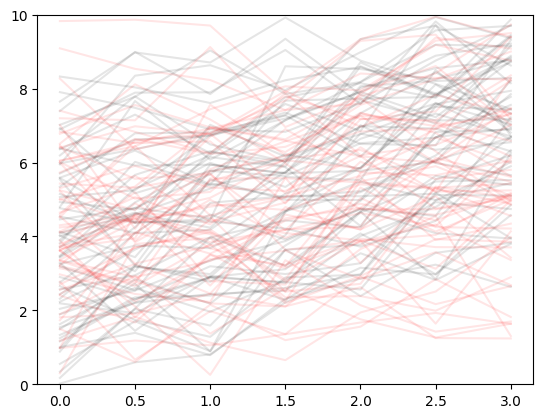

In [3]:


(patient_params, noise_scale), collected_params = simulate_prior_model(key=jax.random.PRNGKey(42),
                                                                       prior_model=prior_model)

measured_hunger = tfpd.TruncatedNormal(patient_params.mean_hunger, noise_scale, low=0., high=10.).sample(
    seed=jax.random.PRNGKey(42))


def log_likelihood(patient_params: Params, noise_scale):
    return jnp.sum(tfpd.TruncatedNormal(patient_params.mean_hunger, noise_scale,
                                        low=0., high=10.).log_prob(measured_hunger)
                   )


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)
import pylab as plt

plt.plot(measure_times, measured_hunger[~intervention_mask, :].T, c='k', alpha=0.1)
plt.plot(measure_times, measured_hunger[intervention_mask, :].T, c='r', alpha=0.1)
plt.ylim(0., 10.)
plt.show()


# Define likelihood
     

# Make a model that is unaware of the effect

In [4]:

def unaware_prior_model():
    noise_scale = yield Prior(tfpd.TruncatedNormal(1., 0.5, low=0.5, high=2.), name='noise_scale')

    prior_h0_mean = yield Prior(tfpd.TruncatedNormal(5., 2., low=0., high=10.), name='prior_h0_mean')
    prior_h0_scale = yield Prior(tfpd.Uniform(0.5, 3.), name='prior_h0_scale')

    prior_h_change_per_hour = yield Prior(tfpd.Uniform(0.5, 2.))
    prior_h_change_control = yield Prior(prior_h_change_per_hour * T, name='prior_h_change_control')

    prior_h_change = prior_h_change_control

    h0 = yield Prior(tfpd.TruncatedNormal(prior_h0_mean, prior_h0_scale,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"h0").parametrised()
    hT = yield Prior(tfpd.TruncatedNormal(h0 + prior_h_change, 1.,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"hT").parametrised()
    mean_hunger = h0[:, None] + measure_times * (hT[:, None] - h0[:, None]) / T
    patient_params = Params(
        mean_hunger=mean_hunger
    )
    return patient_params, noise_scale


unaware_model = Model(prior_model=unaware_prior_model, log_likelihood=log_likelihood)

In [5]:
from jaxns.experimental import EvidenceMaximisation

em = EvidenceMaximisation(model=unaware_model, max_num_epochs=10, gtol=0.1)


Convergence achieved at step 7.:  70%|███████   | 7/10 [07:16<03:06, 62.32s/it]                                                                                                                                                                                                      


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 238558
samples: 2880
phantom samples: 0
likelihood evals / sample: 82.8
phantom fraction (%): 0.0%
--------
logZ=-896.52 +- 0.33
H=-13.32
ESS=274
--------
h0[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
h0[0]: 4.871 +- 0.047 | 4.811 / 4.873 / 4.93 | 4.876 | 4.873
h0[1]: 1.787 +- 0.055 | 1.713 / 1.787 / 1.856 | 1.794 | 1.793
h0[2]: 6.936 +- 0.062 | 6.867 / 6.928 / 7.013 | 6.94 | 6.935
h0[3]: 3.744 +- 0.045 | 3.68 / 3.745 / 3.799 | 3.749 | 3.747
h0[4]: 3.75 +- 0.045 | 3.686 / 3.751 / 3.805 | 3.756 | 3.753
h0[5]: 3.307 +- 0.046 | 3.242 / 3.307 / 3.361 | 3.313 | 3.311
h0[6]: 7.193 +- 0.065 | 7.121 / 7.185 / 7.274 | 7.196 | 7.191
h0[7]: 5.436 +- 0.05 | 5.377 / 5.432 / 5.501 | 5.441 | 5.437
h0[8]: 4.781 +- 0.047 | 4.722 / 4.782 / 4.838 | 4.786 | 4.783
h0[9]: 0.918 +- 0.061 | 0.837 / 0.92 / 0.999 | 0.926 | 0.925
h0[10]: 4.32 +- 0.046 | 4.259 / 4.321 / 4.374 | 4.326 | 4.323
h0[11]: 

/home/albert/git/jaxns/jaxns/plotting.py:47: RuntimeWarning: divide by zero encountered in divide
  efficiency = 1. / num_likelihood_evaluations_per_sample


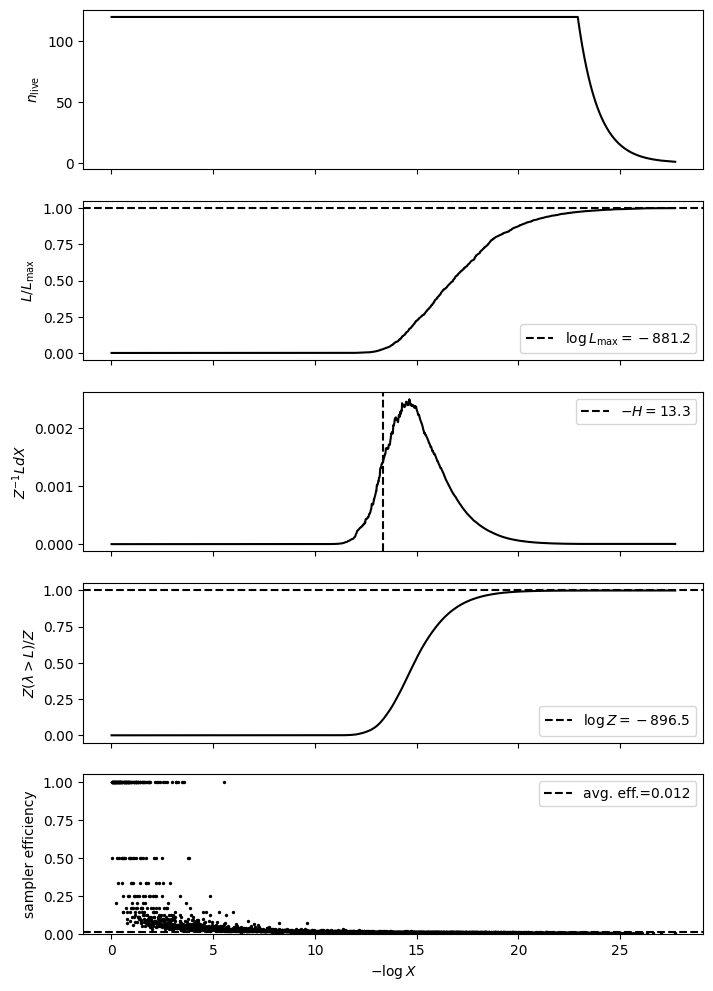

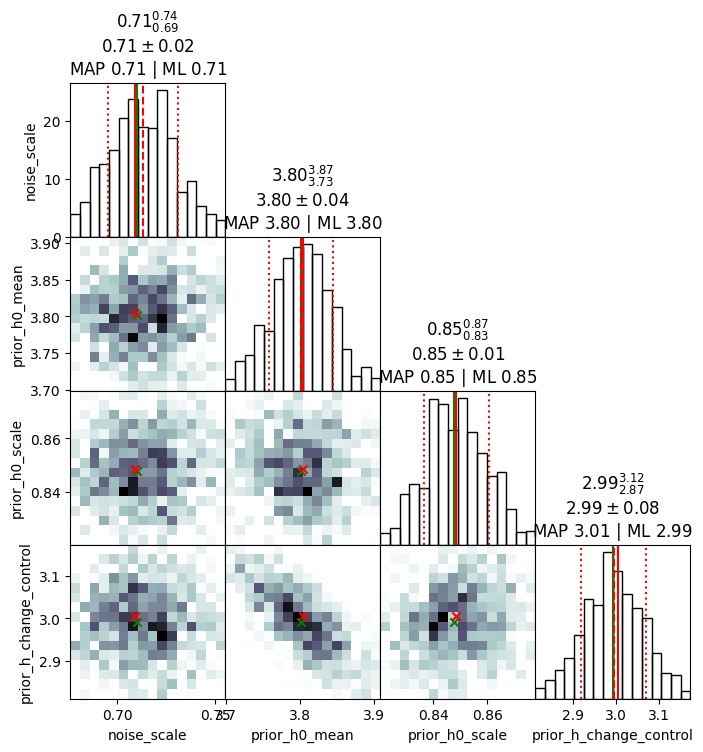

In [6]:
from jaxns import summary, plot_diagnostics, plot_cornerplot

ns_results, params = em.train(num_steps=10)
summary(ns_results, with_parametrised=True)
plot_diagnostics(ns_results)
plot_cornerplot(ns_results, variables=['noise_scale', 'prior_h0_mean', 'prior_h0_scale', 'prior_h_change_control'],
                with_parametrised=True)

In [7]:

def aware_prior_model():
    noise_scale = yield Prior(tfpd.TruncatedNormal(1., 0.5, low=0.5, high=2.), name='noise_scale')

    prior_h0_mean = yield Prior(tfpd.TruncatedNormal(5., 2., low=0., high=10.), name='prior_h0_mean')
    prior_h0_scale = yield Prior(tfpd.Uniform(0.5, 3.), name='prior_h0_scale')

    prior_h_change_per_hour = yield Prior(tfpd.Uniform(0.5, 2.))
    prior_h_change_control = yield Prior(prior_h_change_per_hour * T, name='prior_h_change_control')

    prior_h_change_intervention_factor = yield Prior(tfpd.Uniform(0.1, 1.), name='prior_h_change_intervention_factor')
    prior_h_change_intervention = prior_h_change_intervention_factor * prior_h_change_control

    # Choose right change for intervention.
    prior_h_change = jnp.where(intervention_mask, prior_h_change_intervention, prior_h_change_control)

    h0 = yield Prior(tfpd.TruncatedNormal(prior_h0_mean, prior_h0_scale,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"h0").parametrised()
    hT = yield Prior(tfpd.TruncatedNormal(h0 + prior_h_change, 1.,
                                          low=jnp.zeros((num_trials,)), high=10.),
                     name=f"hT").parametrised()
    mean_hunger = h0[:, None] + measure_times * (hT[:, None] - h0[:, None]) / T
    patient_params = Params(
        mean_hunger=mean_hunger
    )
    return patient_params, noise_scale


aware_model = Model(prior_model=aware_prior_model, log_likelihood=log_likelihood)


Convergence achieved at step 9.:  90%|█████████ | 9/10 [10:41<01:11, 71.29s/it]                                                                                                                                                                                                       


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 316285
samples: 3750
phantom samples: 0
likelihood evals / sample: 84.3
phantom fraction (%): 0.0%
--------
logZ=-899.11 +- 0.31
H=-14.68
ESS=394
--------
h0[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
h0[0]: 4.876 +- 0.046 | 4.819 / 4.873 / 4.934 | 4.868 | 4.877
h0[1]: 1.781 +- 0.059 | 1.706 / 1.782 / 1.852 | 1.783 | 1.79
h0[2]: 6.939 +- 0.06 | 6.867 / 6.936 / 7.018 | 6.925 | 6.935
h0[3]: 3.691 +- 0.046 | 3.633 / 3.692 / 3.748 | 3.687 | 3.695
h0[4]: 3.764 +- 0.046 | 3.706 / 3.765 / 3.821 | 3.76 | 3.768
h0[5]: 3.316 +- 0.048 | 3.254 / 3.319 / 3.378 | 3.313 | 3.321
h0[6]: 7.204 +- 0.062 | 7.125 / 7.2 / 7.286 | 7.188 | 7.199
h0[7]: 5.435 +- 0.048 | 5.377 / 5.43 / 5.496 | 5.425 | 5.434
h0[8]: 4.787 +- 0.046 | 4.731 / 4.783 / 4.844 | 4.779 | 4.789
h0[9]: 0.904 +- 0.067 | 0.819 / 0.907 / 0.985 | 0.909 | 0.916
h0[10]: 4.341 +- 0.045 | 4.284 / 4.339 / 4.395 | 4.335 | 4.343
h0[11]:

/home/albert/git/jaxns/jaxns/plotting.py:47: RuntimeWarning: divide by zero encountered in divide
  efficiency = 1. / num_likelihood_evaluations_per_sample


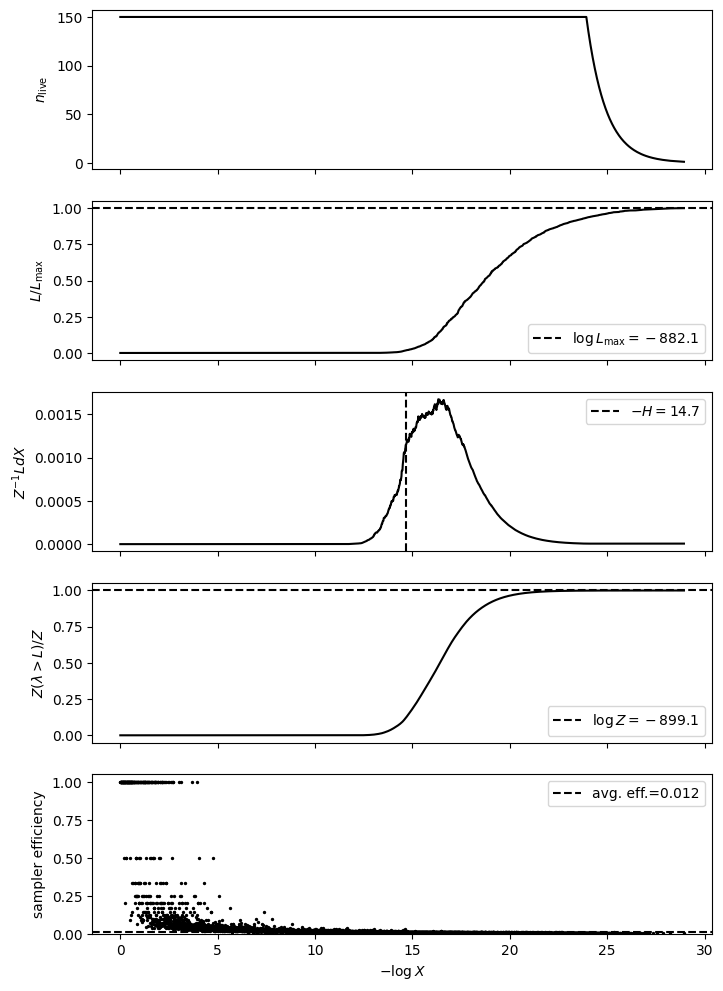

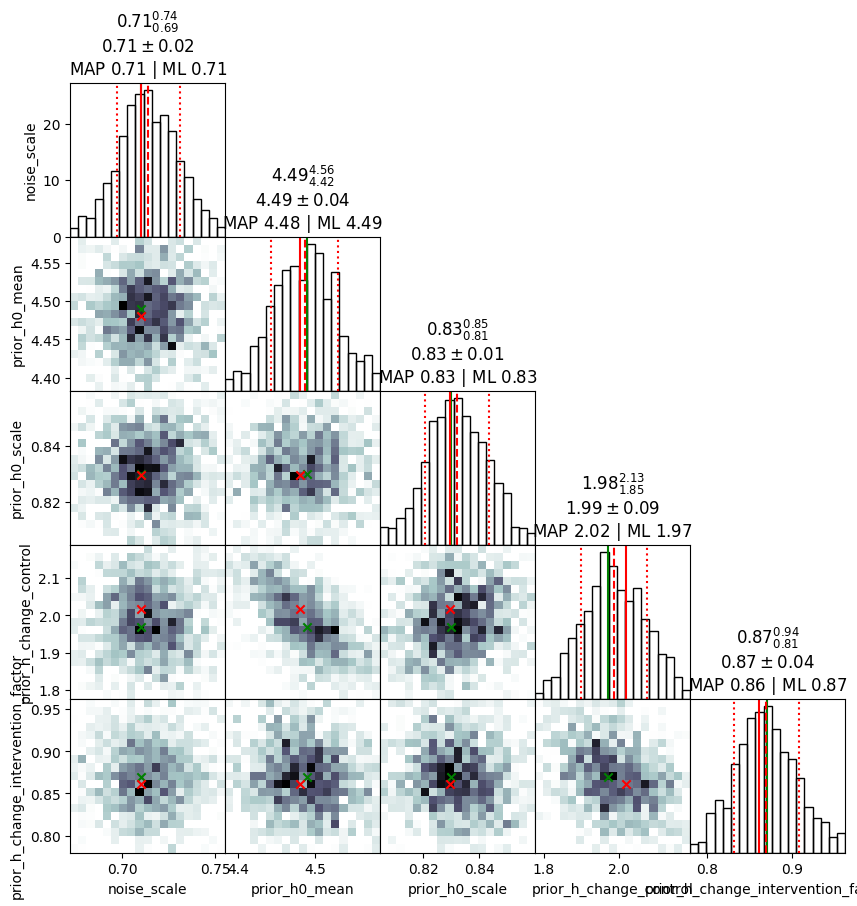

In [8]:
em = EvidenceMaximisation(model=aware_model, max_num_epochs=10, gtol=0.1)

ns_results, params = em.train(num_steps=10)
summary(ns_results, with_parametrised=True)
plot_diagnostics(ns_results)
plot_cornerplot(ns_results, variables=['noise_scale', 'prior_h0_mean', 'prior_h0_scale', 'prior_h_change_control',
                                       'prior_h_change_intervention_factor'],
                with_parametrised=True)
